In [1]:
import time
import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# this function returns the number of times the point fell
# within the unit circle out of n attempts
def in_circle(n):
    coords = np.random.rand(n,2) # random coordinates in (n,2) array
    count = 0
    for i in range(n):
        if (coords[i][0])**2 + (coords[i][1])**2 < 1:
            count += 1
    return count


# this function calculates the pi in parallel and measures
# the runtime
def parallel_pi(num_processors,chunk_size,num_chunks):
    np.random.seed(42)
    pool = mp.Pool(processes=num_processors)
    
    start = time.time()
    
    # we apply the in_circle function N times and
    # the mp package takes care of "feeding" them to the processes
    results = [pool.apply_async(in_circle, (chunk_size,)) for i in range(num_chunks)]
    
    # we close the pool and wait for results
    pool.close()
    pool.join()

    # here we get the K values one by one
    K_values = [result.get() for result in results]

    # ...and estimate the pi by aggregating all the attempts
    pi_n = [4*K_value*(1/chunk_size) for K_value in K_values]    
    pi_estimate = sum(pi_n)*(1/num_chunks)
    
    stop = time.time()
    time_ex = stop-start # runtime
    
    return [pi_estimate, time_ex]

In [3]:
def plot_results(M_values, time_values):
    plt.figure()
    plt.plot(M_values, time_values)
    plt.xlabel("M")
    plt.ylabel("Execution time [s]")
    plt.show()

    speedup = [time_values[0]/i for i in time_values]

    plt.figure()
    plt.plot(M_values, speedup)
    plt.xlabel("M")
    plt.ylabel("Speedup")
    plt.show()

## Experiment with using multiple cores

In [2]:
core_count = mp.cpu_count() # detected number of cores
print(f"{core_count} processors found")
P_values = range(1, core_count+1) # let's try from 1 to P_max

chunk_size = 10000
num_chunks = 1000

print('Number of processes:')

result_values = []
for P in P_values:
    print(P)
    result_values.append( parallel_pi(P, chunk_size, num_chunks) )
    
time_values = [result_values[i][1] for i in range(core_count)]
pi_values = [result_values[i][0] for i in range(core_count)]
pi_errors = [abs(pi_est-np.pi) for pi_est in pi_values]

plot_results(P_values, time_values)
print(pi_values)
print(pi_errors)


16 processors found
Number of processes:
1


NameError: name 'parallel_pi' is not defined

## Experimenting with varying chunk size

#### Using 1 core

Using chunk size: 10
Using chunk size: 100
Using chunk size: 1000
Using chunk size: 10000
Using chunk size: 100000
Using chunk size: 1000000


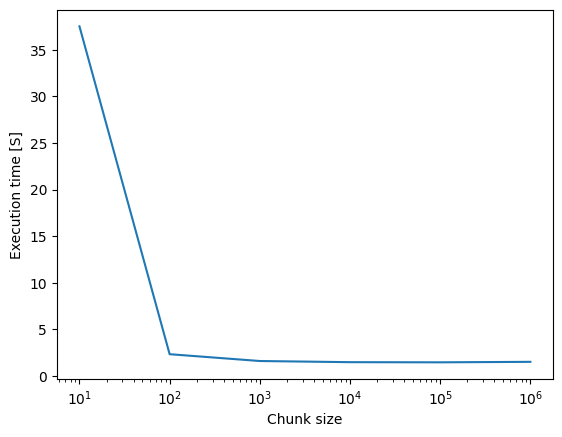

In [5]:
core_count = mp.cpu_count()
num_cores = 1

chunk_sizes = [10, 100, 1000, 10000, 100000, 1000000] # [10, 100, ..., 1e6]

results = []
for size in chunk_sizes:
    print(f"Using chunk size: {size}")
    num_chunks = int(1e6/size)
    results.append(parallel_pi(num_processors=num_cores, chunk_size=size, num_chunks=num_chunks))
    

time_values = [results[i][1] for i in range(6)]
plt.figure()
plt.semilogx(chunk_sizes, time_values)
plt.xlabel("Chunk size")
plt.ylabel("Execution time [S]")
plt.show()
    

#### Using 16 cores

Using chunk size: 10
Using chunk size: 100
Using chunk size: 1000
Using chunk size: 10000
Using chunk size: 100000
Using chunk size: 1000000


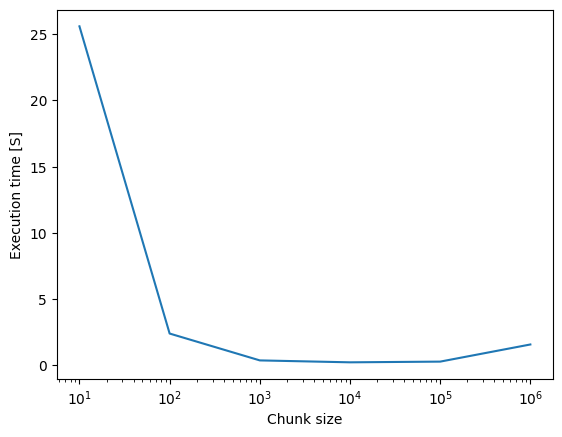

In [6]:
core_count = mp.cpu_count()
num_cores = core_count

chunk_sizes = [10, 100, 1000, 10000, 100000, 1000000] # [10, 100, ..., 1e6]

results = []
for size in chunk_sizes:
    print(f"Using chunk size: {size}")
    num_chunks = np.int64(1e6/size)
    results.append(parallel_pi(num_processors=num_cores, chunk_size=size, num_chunks=num_chunks))
    

time_values = [results[i][1] for i in range(len(chunk_sizes))]
plt.figure()
plt.semilogx(chunk_sizes, time_values)
plt.xlabel("Chunk size")
plt.ylabel("Execution time [S]")
plt.show()

Observations show that for a single core, smaller but a large amount of chunks is better.

For 16 cores we however see that the optimal chunk size grows by a factor 10, meaning we want bigger and fewer chunks.

This maybe makes sense as cores need to syncronize and communicate with each other inbetween working on chunks, and if they chunks are small this may happen often leading to a lot of overhead.

The fall in performance at very large chunk sizes could maybe be explained by the individual cores L1 or L2 cache size, not being able to fit the entire data

## Map-Filter-Reduce

In [3]:
from functools import reduce

def sub_seven(x):
    return x-7

def is_odd(x):
    return x % 2 == 1

def add(x, y):
    return x + y

In [9]:
N = 10000000
x = np.random.randint(10,100, N)

result = map(sub_seven, x)

result = filter(is_odd, result)

result = reduce(add, result, 0)

print(result)


234969946
